# Set up environment

In [1]:
!python -m pip install --upgrade pip
!python -m pip install --upgrade plotly
!python -m pip install scikit-learn-intelex
# !pip install --upgrade dpcpp_cpp_rt

     |████████████████████████████████| 1.6 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 20.6 MB 84 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 68 kB 2.9 MB/s 
     |████████████████████████████████| 15.9 MB 43 kB/s 
     |████████████████████████████████| 292.9 MB 47 kB/s 
     |████████████████████████████████| 4.1 MB 16.7 MB/s 
     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 32.8 MB 59 kB/s 
     |████████████████████████████████| 185.9 MB 57 kB/s 


In [2]:
!pip install --upgrade dpcpp_cpp_rt

# Libraries

In [5]:
import sys
import os
import site
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [1]:
# from sklearnex import patch_sklearn
# from daal4py.oneapi import sycl_context
import numpy as np

# patch_sklearn()

from sklearn import svm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.datasets import load_files
# import HOG
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# img
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.color import rgb2gray

In [7]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list -s image
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip
# !unzip seg_pred.zip
# !unzip seg_test.zip
# !unzip seg_train.zip
!cp -r seg_pred/seg_pred/* seg_pred/
!rm -rf seg_pred/seg_pred
!cp -r seg_test/seg_test/* seg_test/
!rm -rf seg_test/seg_test/
!cp -r seg_train/seg_train/* seg_train/
!rm -rf seg_train/seg_train/

# Data

dimensions of photo: (150, 150, 3)


Text(0.5, 1.0, 'Image test')

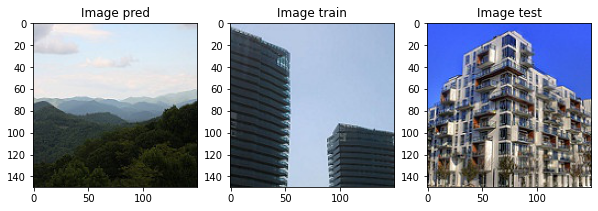

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
img_pred = plt.imread('seg_pred/19527.jpg')
print(f'dimensions of photo: {img_pred.shape}')
img_train = plt.imread('seg_train/buildings/1231.jpg')
img_test = plt.imread('seg_test/buildings/22812.jpg')
ax[0].imshow(img_pred)
ax[1].imshow(img_train)
ax[2].imshow(img_test)
ax[0].set_title('Image pred')
ax[1].set_title('Image train')
ax[2].set_title('Image test')

In [2]:
train_dir='./seg_train'
test_dir='./seg_test'

def load_dataset(path):
  data = load_files(path)
  files = np.array(data['filenames'])
  targets = np.array(data['target'])
  target_labels = np.array(data['target_names'])
  return files, targets, target_labels

x_train_l, y_train, target_labels = load_dataset(train_dir)
x_test_l, y_test, _ = load_dataset(test_dir)
print('Loading complete!')

Loading complete!


# Explore

In [12]:
print('Training set size : ' , x_train_l.shape[0])
print('Testing set size : ', x_test_l.shape[0])
no_of_classes = len(np.unique(y_train))
print('N.O of classes : ', no_of_classes)

Training set size :  14034
Testing set size :  3000
N.O of classes :  6


In [13]:
print(target_labels)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [14]:
print(x_train_l[0])
print(y_train[0])
print(target_labels[0])
print(y_train[0:10])

./seg_train/glacier/6416.jpg
2
buildings
[2 0 5 5 3 4 2 1 2 3]


In [7]:
# # makes y categorial, doesn't work on SVM
# from keras.utils import np_utils
# y_train = np_utils.to_categorical(y_train,no_of_classes)
# y_test = np_utils.to_categorical(y_test,no_of_classes)
# y_train[0] # Note that only one element has value 1(corresponding to its label) and others are 0.

In [8]:
print(len(x_train_l))  #14008
print(len(x_test_l))  # 3000

14034
3000


In [16]:
t=len(x_train_l)+len(x_test_l)
print(len(x_train_l)/t)
print(len(x_test_l)/t)

0.8238816484677703
0.17611835153222966


# Image to array, Grayscale

In [3]:
def convert_image_to_array(files,color_mode='grayscale'):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        img = load_img(file,target_size=(150,150),color_mode=color_mode)
        img = img_to_array(img) 
        if color_mode == 'grayscale':
          img = img.reshape(img.shape[0],-1)
        images_as_array.append(img)
    return images_as_array

In [4]:
x_train = np.array(convert_image_to_array(x_train_l))
print('Training set shape : ',x_train.shape)

x_test = np.array(convert_image_to_array(x_test_l))
print('Test set shape : ',x_test.shape)

Training set shape :  (14034, 150, 150)
Test set shape :  (3000, 150, 150)


In [17]:
# Image dimensions
print(x_train[0].shape)

(150, 150)


In [18]:
print(x_train[0].shape)
# xd = np.c_[x_train[0]]
print(x_train[0][0].shape)
print(x_train[0][0][0].shape)
# gray
# fig=px.imshow(x_train[0].reshape(x_train[0].shape[0], x_train.shape[1]))
# rgb
fig=px.imshow(x_train[0])
fig.show()

(150, 150)
(150,)
()


In [ ]:
# x_train = np.true_divide(x_train, 255)
# x_test = np.true_divide(x_test, 255)

# SVM

## Local Binary Patterns

In [5]:
# import the necessary packages
from skimage import feature
class LocalBinaryPatterns:
	def __init__(self, numPoints, radius):
		# store the number of points and radius
		self.numPoints = numPoints
		self.radius = radius
	def describe(self, image, eps=1e-7):
		# compute the Local Binary Pattern representation
		# of the image, and then use the LBP representation
		# to build the histogram of patterns
		lbp = feature.local_binary_pattern(image, self.numPoints,
			self.radius, method="uniform")
		(hist, _) = np.histogram(
      lbp.ravel(),
      bins=np.arange(0, self.numPoints + 3),
      range=(0, self.numPoints + 2))
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
		# return the histogram of Local Binary Patterns
		return hist

## Histograms of Oriented Gradients

In [6]:
def create_features(img):
  # img is grayscale
  # Flatten the color image
  color_features = img.flatten()
  # gray_img = rgb2gray(img)
  # Hog features of gray image
  hog_features = hog(img, block_norm='L2-Hys', pixels_per_cell=(16,16))
  # Combine color features
  flat_features = np.hstack((color_features, hog_features))
  return flat_features

In [7]:
def create_feature_matrix(imgs):
  feature_list = []
  for _img in imgs:
    img_features = create_features(_img)
    feature_list.append(img_features)
  return np.array(feature_list)

## Img Descriptor

In [17]:
# create_features(x_train[0])
x_train = create_feature_matrix(x_train)
x_test = create_feature_matrix(x_test)

In [18]:
pca = PCA(n_components=2000)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

In [ ]:
clf = svm.SVC(random_state=0)
clf.fit(x_train, y_train)
# clf.score(x_test, y_test)

# TMP test

In [8]:
def mkdesc(imgs, desc, color_mode='grayscale'):
  imgs_desc = []
  shape_ = imgs.shape
  for _img in imgs:
    imgs_desc.append(desc.describe(_img))
  return imgs_desc

In [15]:
print(x_train[0].shape)

(26,)


In [9]:
# 24 points, 8 radious LBP
desc = LocalBinaryPatterns(24, 3)
x_train = np.array(mkdesc(x_train, desc))
x_test = np.array(mkdesc(x_test, desc))

In [ ]:
# 3min?

In [10]:
clf = svm.SVC(random_state=0)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.4726666666666667

In [11]:
clf

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

# Results

In [12]:
from sklearn.metrics import classification_report 

predicted = dict()

predicted['svm'] = clf.predict(x_test)

for name, model in predicted.items():
  print('Classification Report for {0}:\n {1}'.format(
        name,
        classification_report(y_test, predicted[name])))

Classification Report for svm:
               precision    recall  f1-score   support

           0       0.56      0.18      0.27       437
           1       0.63      0.89      0.74       474
           2       0.41      0.33      0.36       553
           3       0.38      0.53      0.44       525
           4       0.60      0.24      0.34       510
           5       0.41      0.67      0.51       501

    accuracy                           0.47      3000
   macro avg       0.50      0.47      0.44      3000
weighted avg       0.49      0.47      0.44      3000



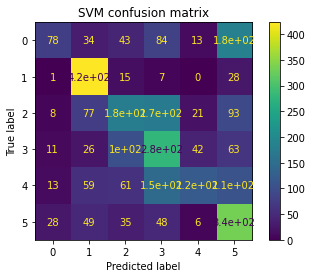

In [13]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, x_test, y_test)
plt.title('SVM confusion matrix')
plt.show()

In [14]:
print(target_labels)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


# tmp

In [ ]:
params = {
    'C': [0.1,1,10],
    'kernel': ['rbf','poly'],
    'gamma': [0.001,0.01,0.1,1,10]
}

svm_clf = GridSearchCV(svm.SVC(), params, cv=5)
svm_clf.fit(x_train_desc, y_train)

In [ ]:
print("Best score: {0}, Best params: {1}".format(
    svm_clf.best_score_, svm_clf.best_params_))
means = svm_clf.cv_results_['mean_test_score']
parameters = svm_clf.cv_results_['params']
for _mean,_param in zip(means, parameters):
  print(_mean, _param)

Best score: 0.494085755979667, Best params: {'C': 10, 'gamma': 10, 'kernel': 'poly'}
0.17899386550424673 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.17899386550424673 {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.17899386550424673 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.17899386550424673 {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.21896833621069006 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.17899386550424673 {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.3061854070657792 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.3202226081268674 {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.3886989836273789 {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
0.46536974435919165 {'C': 0.1, 'gamma': 10, 'kernel': 'poly'}
0.17899386550424673 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.17899386550424673 {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.21889713654972637 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.17899386550424673 {'C': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.3049742256719468 {'C': 1, 'gamma': 0.1, 'ke